<a href="https://colab.research.google.com/github/margaretmz/GANs-in-Art-and-Design/blob/main/2_dcgan_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started: DCGAN for Fashion-MNIST
Author: Margaret Maynard-Reid ([@margaretmz](https://twitter.com/margaretmz))

This Colab notebook is a TensorFlow 2 / Keras implementation of DCGAN, as part of the PyImageSearch University GAN series. 

It is trained with Fashion-MNIST and generates gray-scale 28x28x1 images.

Link to the paper [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).

Table of Contents

>[DCGAN Fashion-MNIST](#scrollTo=wxWgWoUYNNYe)

>>[Import](#scrollTo=wcrOk6pURp50)

>>[Data](#scrollTo=mu11hf0_rqRq)

>>>[Loading](#scrollTo=fswXPGriDWZa)

>>>[Visualization](#scrollTo=PFE71AWEDZBp)

>>>[Preprocessing](#scrollTo=Eo818wWbDY7S)

>>[The Generator](#scrollTo=BY-sz-IFbWr7)

>>[The Discriminator](#scrollTo=9qAUg0qNbXpS)

>>[DCGAN](#scrollTo=X0IOiEj-QNXd)

>>>[Define the DCGAN class](#scrollTo=urgSpXaPQlKk)

>>>[Use Keras Callback to monitor training](#scrollTo=QtlnNc4lQw53)

>>>[The DCGAN model - putting it together](#scrollTo=FzjTO5ZqRLVY)

>>[Compile DCGAN](#scrollTo=9OubidSS_Lrl)

>>[Train DCGAN](#scrollTo=1WhnM4ptN2rp)



## Import

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

Its always a good practice to check the current version of TensorFlow...

In [ ]:
print(tf.version.VERSION)

2.6.0


## Data
The first step is to get data ready for training.


### Loading

In [ ]:
# load the Fashion MNIST dataset and it's OK to use just the training data
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


There are 60,000 training gray scale images in Fashion-MNIST.

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
type(train_images)

numpy.ndarray

### Visualization

I always like to visualize the training data to get an idea of what the images look like. 

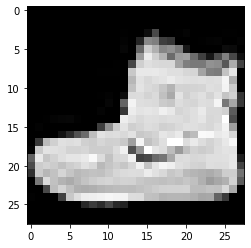

In [ ]:
plt.figure()
plt.imshow(train_images[0], cmap='gray')
plt.show()

### Preprocessing

In [ ]:
# Reshape data and also convert the data type to 'float32'
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = (train_images - 127.5) / 127.5  

(60000, 28, 28)
(60000, 28, 28, 1)


## The Generator

Define the generator model architecture with the Keras `Sequential` API.

Use `ReLU` except for the last layer which has `tanh` as the activation.

The job of the generator is to make images, to do so in DCGAN, we feed random noise as input to the generator and upsample till the desired image size becomes 28x28x1.

In [ ]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 1

In [ ]:
def build_generator():
		# create a Keras Sequential model 
		model = Sequential(name="generator")

		# prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
		model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())

		# 1D => 3D: reshape the output of the previous layer 
		model.add(layers.Reshape((7, 7, 256)))
	
		# upsample to 14x14: apply a transposed CONV => BN => RELU
		model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
		model.add(layers.BatchNormalization())
		model.add((layers.ReLU()))
	
		# upsample to 28x28: apply a transposed CONV => BN => RELU
		model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
		model.add(layers.BatchNormalization())
		model.add((layers.ReLU()))

		# final layer: Conv2D with tanh activation
		model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh"))

		# return the generator model
		return model

In [ ]:
# build the generator model
generator = build_generator() 

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
re_lu (ReLU)                 (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 128)       0 

## The Discriminator

Define the discriminator model architecture with the Keras `Sequential` API

In [ ]:
def build_discriminator(width, height, depth, alpha=0.2):
		# create a Keras Sequential model
		model = Sequential(name="discriminator")
		input_shape = (height, width, depth)

		# first set of CONV => BN => leaky ReLU layers
		model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", 
			input_shape=input_shape))
		model.add(layers.BatchNormalization())
		model.add(layers.LeakyReLU(alpha=alpha))

		# second set of CONV => BN => leacy ReLU layers
		model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
		model.add(layers.BatchNormalization())
		model.add(layers.LeakyReLU(alpha=alpha))

		# flatten and apply dropout
		model.add(layers.Flatten())
		model.add(layers.Dropout(0.3))

		# sigmoid in the last layer outputs a single value for binary classification
		model.add(layers.Dense(1, activation="sigmoid"))

		# return the discriminator model
		return model

In [ ]:
# build the discriminator model
discriminator = build_discriminator(28, 28, 1) 

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)            

## DCGAN

### Define the DCGAN class
Subclass `keras.Model` and override `train_step()` to implement the DCGAN architecture. This is where the magic happens and the heart of the DCGAN implementation. 

In [ ]:
class DCGAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super().__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")
  
  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(DCGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
  
  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):

    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
    with tf.GradientTape() as tape:
      # Compute discriminator loss on real images
      pred_real = self.discriminator(real_images, training=True)
      d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

      # Compute discriminator loss on fake images
      fake_images = self.generator(noise)
      pred_fake = self.discriminator(fake_images, training=True)
      d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

      # total discriminator loss
      d_loss = (d_loss_real + d_loss_fake)/2
    # Compute discriminator gradients
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    # Update discriminator weights
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    # Step 2. Train the generator (do not update weights of the discriminator)
    # G wants D to think the fake images are real (label as 1)
    misleading_labels = tf.ones((batch_size, 1)) 

    with tf.GradientTape() as tape:
      fake_images = self.generator(noise, training=True)
      pred_fake = self.discriminator(fake_images, training=True)
      g_loss = self.loss_fn(misleading_labels, pred_fake)
    # Compute generator gradients
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    # Update generator weights
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

### Use Keras Callback to monitor training

I use the seed noise to create images (with the generator model) throughout the training to see the progress of the generator. Also save the generator model at the end of the training which could potentially be used for inference later.

In [ ]:
# Create random noise seed for visualization during traing
seed = tf.random.normal([16, LATENT_DIM])

The nice thing about overriding `train_step()` of `keras.Model()` is that we can subclass `Callback` to monitor our DCGAN training.

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        # random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # generated_images = self.model.generator(random_latent_vectors)
        generated_images = self.model.generator(seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

### The DCGAN model - putting it together

In [ ]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

## Compile DCGAN

Compile the `dcgan` model, with the `Adam` optimizer, learning rate of 0.0002, and the **Binary Cross Entropy** loss functionas recommended by the paper. In future GAN tutorials, you will learn other loss functions for other GAN variants.

In [ ]:
LR = 0.0002 # learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

## Train DCGAN
Now we simply call `model.fit()` to traing the `dcgan` model!

Epoch 1/50
1875/1875 [==============================] - 41s 12ms/step - d_loss: 0.1623 - g_loss: 0.8170


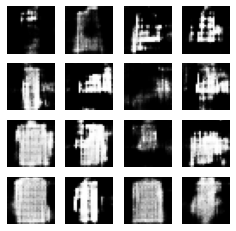

Epoch 2/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6038 - g_loss: 1.1262


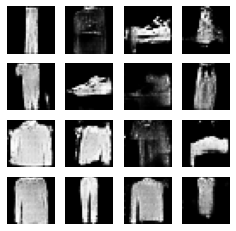

Epoch 3/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6605 - g_loss: 0.9416


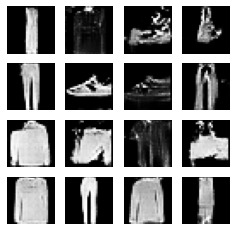

Epoch 4/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6645 - g_loss: 0.8863


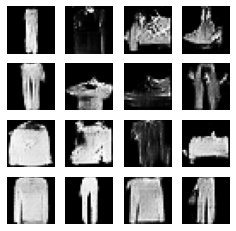

Epoch 5/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6659 - g_loss: 0.8618


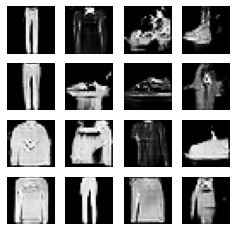

Epoch 6/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6644 - g_loss: 0.8513


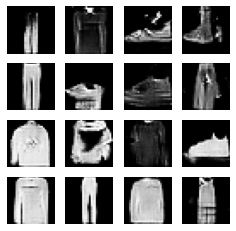

Epoch 7/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6670 - g_loss: 0.8414


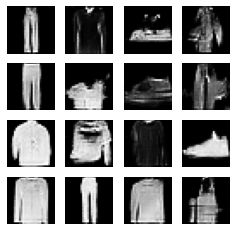

Epoch 8/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6688 - g_loss: 0.8342


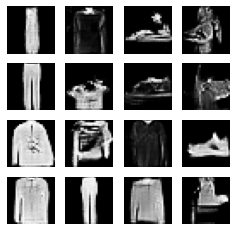

Epoch 9/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6713 - g_loss: 0.8271


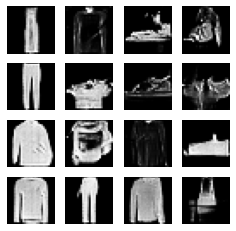

Epoch 10/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6706 - g_loss: 0.8249


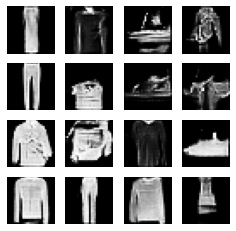

Epoch 11/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6709 - g_loss: 0.8244


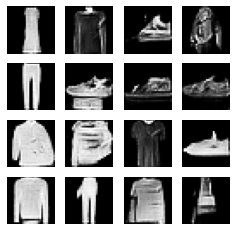

Epoch 12/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6729 - g_loss: 0.8181


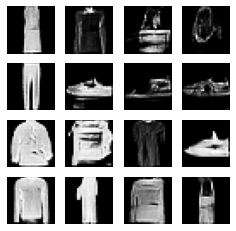

Epoch 13/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6710 - g_loss: 0.8150


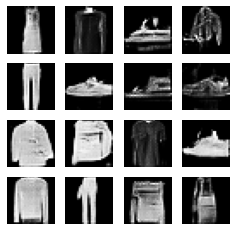

Epoch 14/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6695 - g_loss: 0.8167


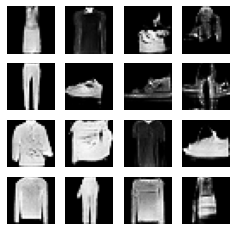

Epoch 15/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6700 - g_loss: 0.8171


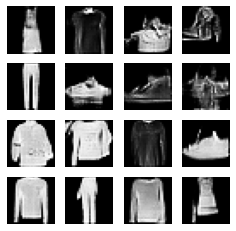

Epoch 16/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6685 - g_loss: 0.8192


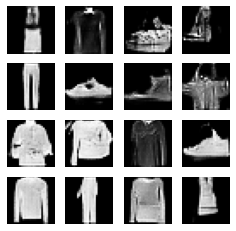

Epoch 17/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6696 - g_loss: 0.8162


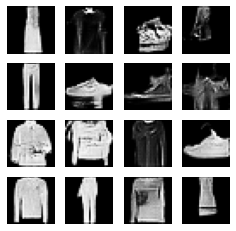

Epoch 18/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6699 - g_loss: 0.8182


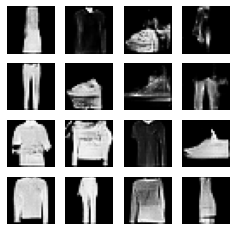

Epoch 19/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6691 - g_loss: 0.8135


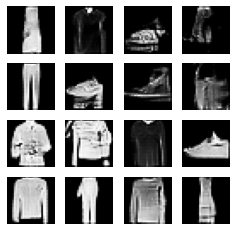

Epoch 20/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6686 - g_loss: 0.8141


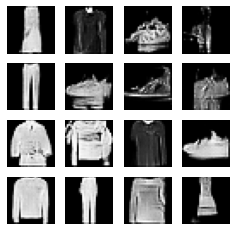

Epoch 21/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6683 - g_loss: 0.8181


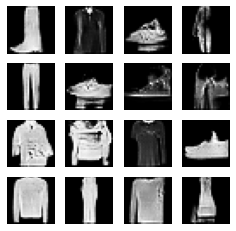

Epoch 22/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6693 - g_loss: 0.8087


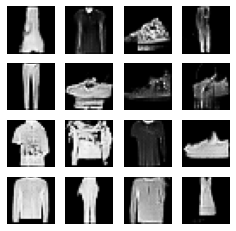

Epoch 23/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6700 - g_loss: 0.8146


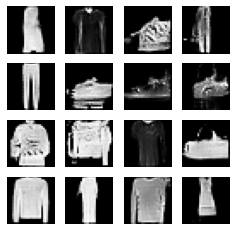

Epoch 24/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6698 - g_loss: 0.8148


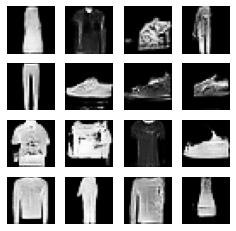

Epoch 25/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6694 - g_loss: 0.8099


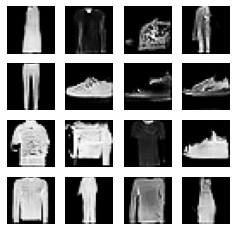

Epoch 26/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6684 - g_loss: 0.8126


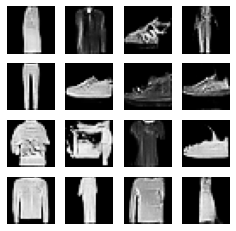

Epoch 27/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6691 - g_loss: 0.8148


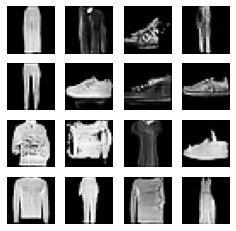

Epoch 28/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6707 - g_loss: 0.8085


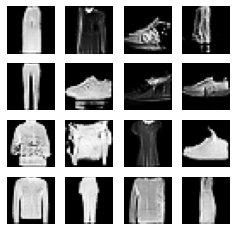

Epoch 29/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6686 - g_loss: 0.8091


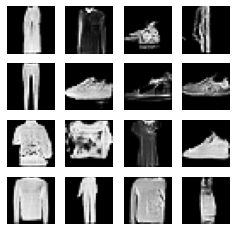

Epoch 30/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6689 - g_loss: 0.8095


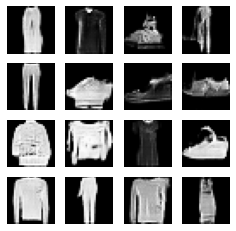

Epoch 31/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6694 - g_loss: 0.8049


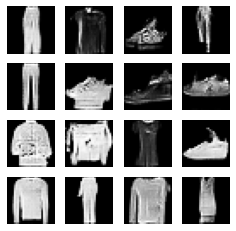

Epoch 32/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6689 - g_loss: 0.8123


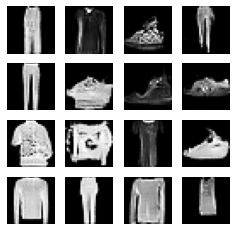

Epoch 33/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6683 - g_loss: 0.8055


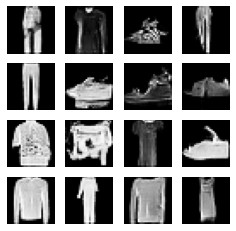

Epoch 34/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6681 - g_loss: 0.8055


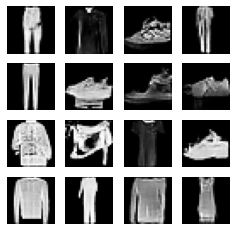

Epoch 35/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6684 - g_loss: 0.8058


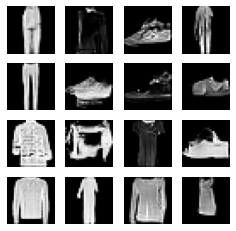

Epoch 36/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6686 - g_loss: 0.8080


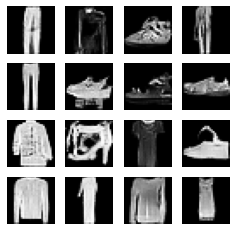

Epoch 37/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6682 - g_loss: 0.8053


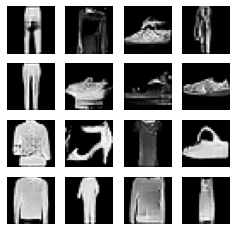

Epoch 38/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6674 - g_loss: 0.8090


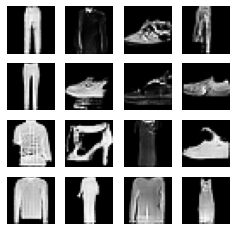

Epoch 39/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6693 - g_loss: 0.8062


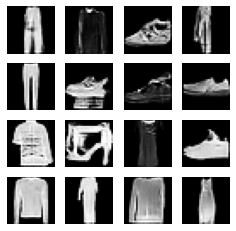

Epoch 40/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6676 - g_loss: 0.8071


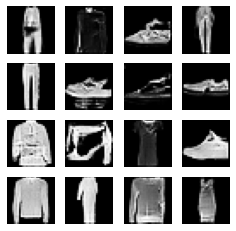

Epoch 41/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6656 - g_loss: 0.8105


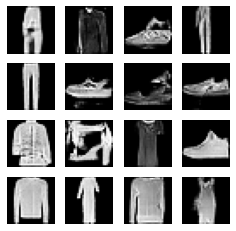

Epoch 42/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6670 - g_loss: 0.8070


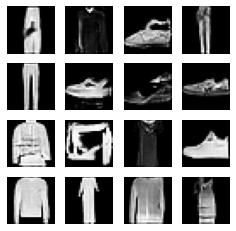

Epoch 43/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6680 - g_loss: 0.8107


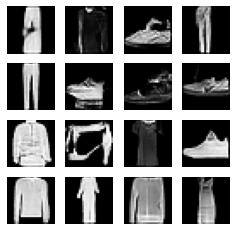

Epoch 44/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6659 - g_loss: 0.8110


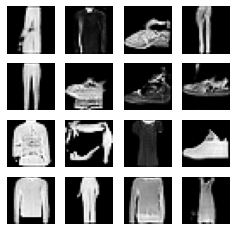

Epoch 45/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6661 - g_loss: 0.8106


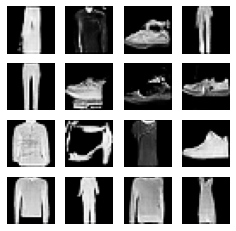

Epoch 46/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6665 - g_loss: 0.8074


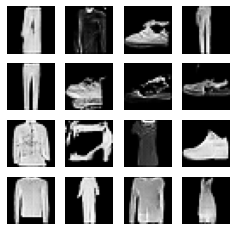

Epoch 47/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6658 - g_loss: 0.8086


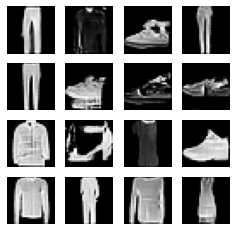

Epoch 48/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6656 - g_loss: 0.8075


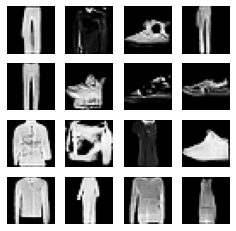

Epoch 49/50
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6659 - g_loss: 0.8076


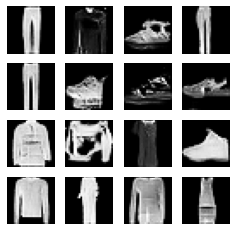

Epoch 50/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6658 - g_loss: 0.8056


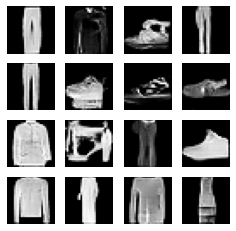

In [ ]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])